## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import nltk.data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import AlbertTokenizer
import transformers

from text_data import TextDataset5
from albert import CustomAlbert
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv')
train = pd.read_csv(f'{path}train.csv')

In [3]:
%%time
tokenizer = AlbertTokenizer.from_pretrained('albert-large-v2')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



CPU times: user 11.9 s, sys: 166 ms, total: 12 s
Wall time: 12.3 s


In [4]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [7]:
num_workers = 10
bs = 1
TextDataset = TextDataset5

In [8]:
bs_test = 1
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [9]:
lr = 0.0005
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 6
grad_accum = 8
weight_decay = 0.01
model_name = 'siamese_albert_1'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [10]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.albert, lr / 100, weight_decay)
    )

There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


Fold 1 started at Wed Jan 29 07:33:05 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


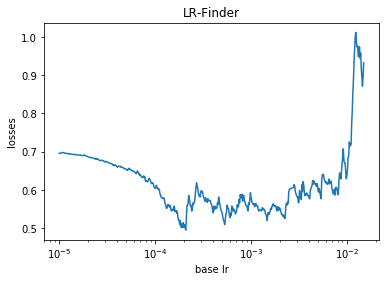

epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.54599 - spearmanr 0.037095
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.5491 - spearmanr 0.16968


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.16968
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.49414 - spearmanr 0.27398
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.4718 - spearmanr 0.36631
best model: epoch 1 - 0.36631
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.47368 - spearmanr 0.34019
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.54196 - spearmanr 0.15658
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.52931 - spearmanr 0.071865
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.52972 - spearmanr 0.17
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.51804 - spearmanr 0.14465
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.52446 - spearmanr 0.18044
model not improved for 3 epochs
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.5119 - spearmanr 0.18493
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.51451 - spearmanr 0.20143
model not improved for 4 epochs
TRAINING END: Best score achieved on epoch 1 - 0.36631
Starting inference for model: checkpoints/siamese_albert_1_fold_1_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_1_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 2 started at Wed Jan 29 10:14:00 2020
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.54785 - spearmanr 0.01887
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.53683 - spearmanr 0.1017
best model: epoch 0 - 0.1017
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.53311 - spearmanr 0.045249
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.52587 - spearmanr 0.1463
best model: epoch 1 - 0.1463
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.52118 - spearmanr 0.12586
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.52413 - spearmanr 0.16447
best model: epoch 2 - 0.16447
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.51768 - spearmanr 0.14336
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.5203 - spearmanr 0.16617
best model: epoch 3 - 0.16617
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.516 - spearmanr 0.15451
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.52074 - spearmanr 0.16821
best model: epoch 4 - 0.16821
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.51414 - spearmanr 0.16704
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.51892 - spearmanr 0.1742
best model: epoch 5 - 0.1742
TRAINING END: Best score achieved on epoch 5 - 0.17420
Starting inference for model: checkpoints/siamese_albert_1_fold_2_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_2_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 3 started at Wed Jan 29 12:52:16 2020
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.55219 - spearmanr 0.014178
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.53257 - spearmanr 0.041859
best model: epoch 0 - 0.041859
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.52158 - spearmanr 0.14039
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.50751 - spearmanr 0.21834
best model: epoch 1 - 0.21834
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.50718 - spearmanr 0.20291
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.50167 - spearmanr 0.23365
best model: epoch 2 - 0.23365
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.49847 - spearmanr 0.23401
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.49768 - spearmanr 0.24701
best model: epoch 3 - 0.24701
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.4929 - spearmanr 0.25815
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.493 - spearmanr 0.25893
best model: epoch 4 - 0.25893
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.48878 - spearmanr 0.27835
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.49327 - spearmanr 0.26126
best model: epoch 5 - 0.26126
TRAINING END: Best score achieved on epoch 5 - 0.26126
Starting inference for model: checkpoints/siamese_albert_1_fold_3_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_3_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 4 started at Wed Jan 29 15:30:37 2020
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.54944 - spearmanr 0.022944
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.53445 - spearmanr 0.087901
best model: epoch 0 - 0.087901
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.53068 - spearmanr 0.089904
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.52043 - spearmanr 0.18013
best model: epoch 1 - 0.18013
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.51977 - spearmanr 0.16643
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.51297 - spearmanr 0.19842
best model: epoch 2 - 0.19842
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.51545 - spearmanr 0.18989
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.51295 - spearmanr 0.19678
model not improved for 1 epochs
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.51472 - spearmanr 0.19392
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.51082 - spearmanr 0.20359
best model: epoch 4 - 0.20359
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.51216 - spearmanr 0.2101
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.51003 - spearmanr 0.20938
best model: epoch 5 - 0.20938
TRAINING END: Best score achieved on epoch 5 - 0.20938
Starting inference for model: checkpoints/siamese_albert_1_fold_4_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_4_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 5 started at Wed Jan 29 18:08:59 2020
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.5495 - spearmanr 0.023448
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.52974 - spearmanr 0.084956
best model: epoch 0 - 0.084956
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.53189 - spearmanr 0.073841
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.52039 - spearmanr 0.18372
best model: epoch 1 - 0.18372
epoch 2: 	 Start training...


KeyboardInterrupt: 

In [11]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomAlbert(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [ ]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

In [ ]:
np.array(opt_ds), np.array(opt_indices)

In [ ]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [ ]:
get_cvs(oofs, y, ix)

In [ ]:
get_cvs(oofs_alt, y, ix)

In [ ]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [ ]:
sample_submission.head()

In [ ]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [ ]:
pd.DataFrame(oofs, columns=TARGETS)

In [ ]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

In [ ]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

In [ ]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

In [ ]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

In [ ]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')